# GTA HS20 - Übung 12: Analyse von Bewegungsdaten 2

## Ziel der Übung

Das Ziel dieser Übung ist es, Bewegungsdaten mit Kontext zu erweitern. Mithilfe dieses Kontexts können zusätzliche Aussagen über Mobilität gemacht werden (z.B. warum oder wie jemand reist). Wir werden insbesondere die folgenden Aspekte betrachten: 

- __Teil 1:__ Extraktion von Points of Interest (POI) um Haltepunkte herum.
- __Teil 2:__ Extraktion von ÖV-Haltestellen um Reiserouten herum.
- __Teil 3:__ Analyse der Korrelation zwischen Strassentyp und Geschwindigkeit.

## Vorgehen

### 1) Vorüberlegung: Was sind relevante Kontextdaten von Mobilität?
In den letzten Übungen haben wir bereits verschiedene Aspekte von Mobilität beleuchtet. Heute wollen wir Bewegungsdaten im Kontext in dem sie unweigerlich stattfinden betrachten.

Überlegen sie sich welche Kontextfaktoren interessant sein könnten, weil sie z.B. Mobilität beeinflussen oder uns erlauben zusätzliche Schlüsse zu ziehen.

* Wie wählen wir die Orte zu denen wir reisen?
* Was beeinflusst unsere Transportmittelwahl? 
* Welche Rückschlüsse können wir mit raum-zeitlichem Kontext auf Verkehrsmittel und Aktivitäten ziehen?

### 2) Übersicht über Funktionen und das Programm bekommen
Wir werden in den drei Teilen die oben genannten Funktionen implementieren. Als Kontextdaten verwenden wir OpenStreetMap (OSM) Daten, welche vielerorts gebraucht werden und unter https://www.openstreetmap.org betrachtet werden können.

Die Orte, an denen sie Code verändern müssen sind mit `TODO` gekennzeichnet.

Import und Definitionen:
Der folgende Codeblock importiert die verwendeten Bibliotheken und initialisiert Elemente die für die interaktive Darstellung der Triplegs benötigt werden.

In [1]:
import os
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import pygeos
import pyrosm
from pyrosm import OSM
import shapely
from shapely import wkt
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from ipywidgets import HTML
from ipyleaflet import Map, CircleMarker, Marker, Popup, GeoData
import ipywidgets as ipyw

from analyse_von_bewegungsdaten_functions import pygeos_geometry_to_shapely

Die nachfolgend benutzten OSM Daten wurden via https://extract.bbbike.org heruntergeladen. Für grössere Regionen können sie aber z.B. auch via https://download.geofabrik.de heruntergeladen werden. Die Daten stehen in verschiedenen Formaten zur Verfügung. Das `.pbf` Format ist sehr kompakt und für OSM Daten optimiert, weshalb wir es hier verwenden. Dateien in diesem Format können jedoch nicht einfach "als Text" angeschaut werden (im Gegensatz zu z.B. https://geojson.org).

Wir benutzen die Bibliothek `pyrosm` um die `.pbf`-Datei zu lesen und bestimmte Subsets der Daten als GeoDataFrame zu extrahieren. `pyrosm` ist in Verion 0.5.3 verfügbar - oft werden Bibliotheken ab Version 1.0 als _stabil_ betrachtet. Dementsprechend müssen wir teils mit eigenen Funktionen ein bisschen nachhelfen (z.B. stellt `pygeos_geometry_to_shapely` sicher, dass wir nur `shapely`-Geometrien haben die wir weiterverwenden können) und es kann auch zu verschiedenen Warnungen kommen. Als erstes erstellen wir ein `OSM`-Objekt und lesen Daten in und um Beijing ein (wo auch unsere Mobilitätsdaten her kommen).

In [2]:
osm = OSM('input_data/beijing.osm.pbf')

Als Beispiel was wir damit machen können wollen wir alle Gebäude im importierten Bereich extrahieren und auf einer Karte darstellen. Nutzen sie die Funktion `plot`, welche von der `geopandas`-Bibliothek für `GeoDataFrames` zur Verfügung gestellt wird.

e:\data\teaching\20hs gta\pyrosm\pyrosm\pyrosm\buildings.py:38: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf = prepare_geodataframe(nodes, node_coordinates, ways,


<AxesSubplot:>

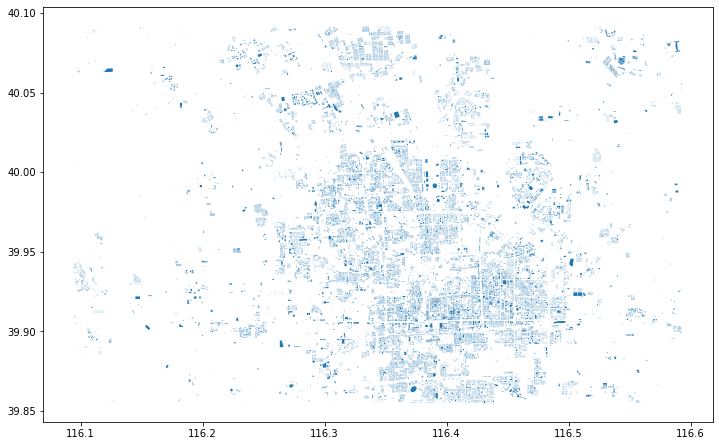

In [3]:
buildings = osm.get_buildings()
buildings['geometry'] = buildings.apply(lambda r: pygeos_geometry_to_shapely(r.geometry), axis=1)
buildings = buildings.set_geometry('geometry')
# TODO Create a figure that shows all buildings using panda's plot function.
buildings.plot(figsize=(12, 8))

Wir können natürlich auch einzelne Gebäude und deren Attribute (wie auf OpenStreetMap gespeichert) anschauen. Nutzen sie Kombinationen von `.head(...)` und `['...']` um verschiedene Attribute des `GeoDataFrame`s zu betrachten. Mit `.columns` können sie alle Kolonnennamen anzeigen. Betrachten sie insbesondere die `tags`, in denen weitere Daten zum Objekt gespeichert sind.

In [4]:
# TODO Examine the data using the .head(...) function.
buildings.head(3)

,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,...,source,wikipedia,id,timestamp,version,tags,osm_type,geometry,start_date,changeset
0,None,None,None,None,None,None,None,None,None,国家大剧院,...,None,en:National Centre for the Performing Arts (Ch...,4974233,0,-1,"{""name:de"":""Nationales Zentrum f\u00FCr Darste...",way,"POLYGON ((116.38360 39.90402, 116.38317 39.904...",NaN,NaN
1,None,None,None,None,None,None,None,None,None,None,...,None,None,24817887,0,-1,"{""name:zh"":""\u751C\u6C34\u56ED\u5546\u52A1\u4E...",way,"POLYGON ((116.47607 39.92356, 116.47636 39.923...",NaN,NaN
2,None,None,None,None,None,None,None,None,None,端门,...,None,None,25097188,0,-1,"{""name:en"":""Duanmen"",""name:ru"":""\u0432\u0440\u...",way,"POLYGON ((116.39049 39.90916, 116.39050 39.909...",NaN,NaN


Im ersten Schritt wollen wir jetzt aber Points of Interest (POI) extrahieren und mit den Bewegungsdaten verknüpfen.

### 3) POI aus OSM extrahieren und mit Haltepunkten verknüpfen

Sie können sich vorstellen, dass wir gewisse Aussagen über den Grund einer Reise machen können, wenn wir wissen was es am Zielpunkt in der Umgebung gibt. So ist es z.B. naheliegend, dass wir in ein Universitätsviertel gehen um zu Studieren, in ein Wohnquartier wenn wir nach Hause gehen, oder in ein Gebiet mit vielen Restaurants und Bars um Freunde zu treffen. 

#### POI aus OSM

Um dieser Intuition zu folgen, extrahieren wir nachfolgend POI von OpenStreetMap und verknüpfen sie räumlich mit den Haltepunkten. Zuerste definieren wir einen Filter, welche OSM-Objekte mit dem Attribut `amenity` oder `shop` aus dem OSM-Datensatz extrahiert. Diese Tags sind in den OSM-Daten sehr weit verbreitet, da sie relativ allgemein verschiedene Objekte beschreiben. Unter https://wiki.openstreetmap.org/wiki/DE:Key:amenity, https://wiki.openstreetmap.org/wiki/DE:Key:shop und https://taginfo.openstreetmap.org können sie mehr zu den OSM-Tags erfahren.

Passen sie den Filter unten an. Benutzen sie dazu das Beispiel unter https://pyrosm.readthedocs.io/en/latest/basics.html#Read-Points-of-Interest.

In [5]:
# TODO Implement custom_filter that filters POI with amenity and shop tags.
custom_filter = {'amenity': True, 'shop': True}
pois = osm.get_pois(custom_filter=custom_filter)
pois['geometry'] = pois.apply(lambda r: pygeos_geometry_to_shapely(r.geometry), axis=1)
pois = pois.set_geometry('geometry')

e:\data\teaching\20hs gta\pyrosm\pyrosm\pyrosm\pois.py:30: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf = prepare_geodataframe(nodes, node_coordinates, ways,


Wir können diese Daten nun auch auf einer Karte anzeigen, sowie wiederum mit `.head(...)` inspizieren.

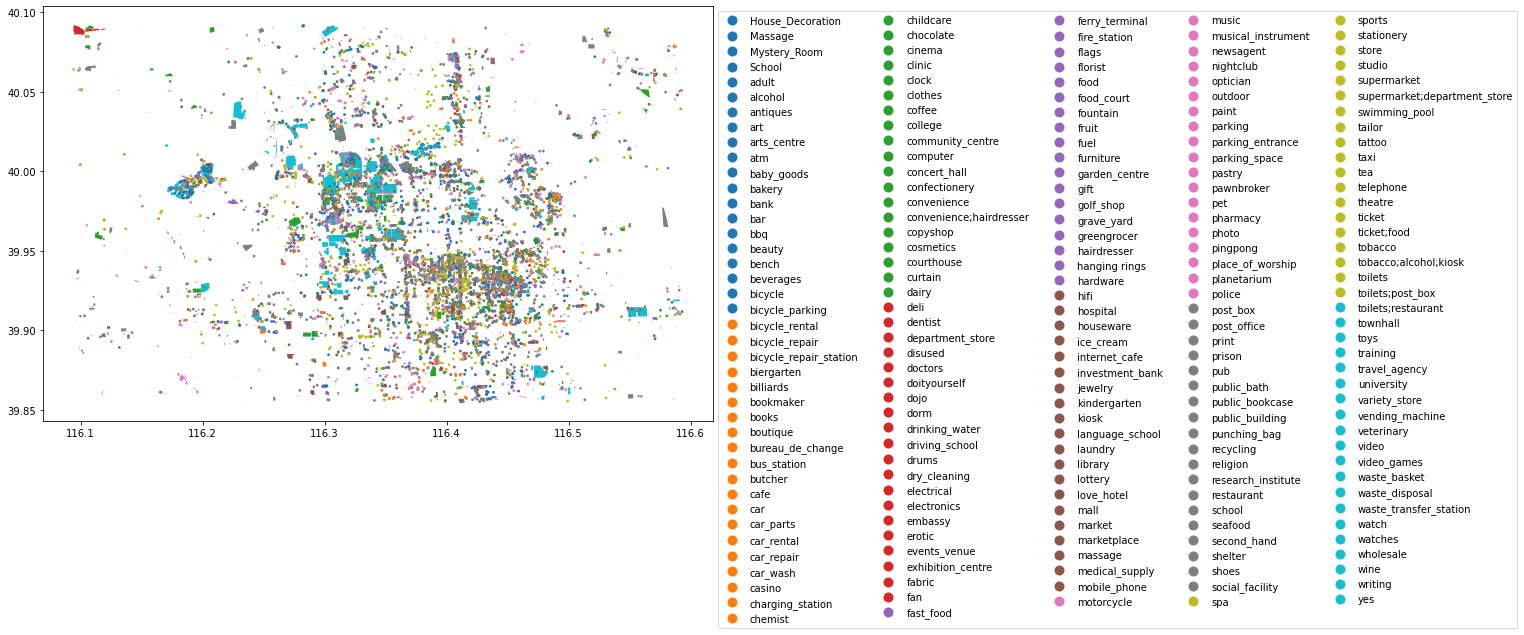

In [6]:
# Gather info about POI type (combines the tag info from "amenity" and "shop").
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, 
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

In [7]:
# TODO Inspect the DataFrame using .head(...), .columns, etc.
pois.head(3)

,lon,tags,id,changeset,timestamp,version,lat,addr:city,addr:country,addr:full,...,clothes,organic,religion,second_hand,shop,geometry,osm_type,building:levels,social_facility,poi_type
0,116.449760,None,60170164,0.0,0,0,39.931103,None,None,None,...,None,None,None,None,books,POINT (116.44976 39.93110),node,NaN,NaN,restaurant
1,116.267502,"{""fee"":""no""}",269492188,0.0,0,0,39.980869,None,None,None,...,None,None,None,None,None,POINT (116.26750 39.98087),node,NaN,NaN,toilets
2,116.413124,"{""created_by"":""Potlatch 0.9c""}",269693162,0.0,0,0,39.881676,None,None,None,...,None,None,None,None,None,POINT (116.41312 39.88168),node,NaN,NaN,parking


#### Haltepunkte vom GeoLife-Datensatz

Als Datensatz verwenden wir dieses Mal GeoLife (https://www.microsoft.com/en-us/download/details.aspx?id=52367), da hierbei einzelne Personen getrackt wurden, und nicht "nur" Taxis. Lesen sie den Datensatz mittels der `pandas`-Funktion `.read_csv` ein. Mit `wkt.loads(...)` wandeln wir den well-known-text, welcher in der Geometrie-Kolonne gespeichert ist in ein `shapely`-Objekt um. Mittels `gpd.GeoDataFrame(...)` können wir das `pandas`-DataFrame dann in ein `geopandas`-DataFrame umwandeln.

<AxesSubplot:>

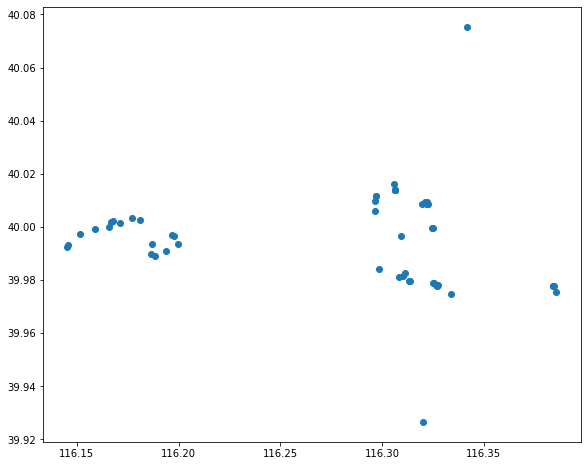

In [8]:
# TODO Use .read_csv(...) to read the GeoLife dataset (stored in the 'input_data' folder).
staypoints = pd.read_csv('input_data/geolife_staypoints.csv')
staypoints['geometry'] = staypoints['geometry'].apply(wkt.loads)
staypoints = gpd.GeoDataFrame(staypoints, crs='epsg:4326')

staypoints.plot(figsize=(16, 8))

Vergessen sie wiederum nicht, sich die Daten mit `.head(...)` anzuschauen.

In [9]:
# TODO Examine the data using .head(...), .columns, etc.
staypoints.head(3)

,start_time,finish_time,geometry,label,elevation,user_id,place_id
0,1224731105,1224731115,POINT (116.29872 39.98399),0,62.890400,0.0,1.0
1,1224736482,1224736492,POINT (116.32480 39.99972),1,53.644800,0.0,1.0
2,1224755731,1224756149,POINT (116.32205 40.00934),2,49.106667,0.0,1.0


#### Umwandlung in projiziertes Koordinatensystem, Puffern und spatial Join

Im nächsten Schritt wollen wir das Koordinatensystem von WGS 1984 auf EPSG:4479 umstellen, da das letztere uns erlaubt, Längen in Meter anzugeben. `geopandas` offeriert dazu die Funktion `.to_crs(...)`. Kreieren sie dann mit der Funktion `buffer(dist)` einen Puffer um die Haltepunkte, und nutzen sie die `gpd.sjoin(...)`-Funktion um einen räumlichen Join zwischen den gepufferten Haltepunkten und den POI durchzuführen. Sehen sie sich die Daten mit `.head(...)` an und überprüfen sie ob die Ergebnisse Sinn machen.

In [10]:
# TODO Project the data into the coordinate system EPSG:4479.
staypoints_4479 = staypoints.to_crs('EPSG:4479')
pois_4479 = pois.to_crs('EPSG:4479')
staypoints_buffer = staypoints_4479.copy()
# TODO Create a buffer of reasonable size around the staypoints.
staypoints_buffer['geometry'] = staypoints_buffer.buffer(150)

# TODO Join the two GeoDataFrames using geopanda's sjoin function (use how='left').
staypoints_pois = gpd.sjoin(staypoints_buffer, pois_4479, how='left')
staypoints_pois = staypoints_pois.reset_index()
staypoints_pois.head(3)

,index,start_time,finish_time,geometry,label,elevation,user_id,place_id,index_right,lon,...,bicycle,clothes,organic,religion,second_hand,shop,osm_type,building:levels,social_facility,poi_type
0,0,1224731105,1224731115,"POLYGON ((-2168076.032 4387318.692, -2168076.7...",0,62.8904,0.0,1.0,488.0,116.298882,...,None,None,None,None,None,None,node,NaN,NaN,bank
1,0,1224731105,1224731115,"POLYGON ((-2168076.032 4387318.692, -2168076.7...",0,62.8904,0.0,1.0,1275.0,116.298912,...,None,None,None,None,None,None,node,NaN,NaN,bank
2,0,1224731105,1224731115,"POLYGON ((-2168076.032 4387318.692, -2168076.7...",0,62.8904,0.0,1.0,10354.0,NaN,...,NaN,NaN,NaN,None,NaN,None,way,None,None,parking


Wir können nun zählen, wie oft ein bestimmter Typ POI in der Umgebung eines Haltepunkts vorgekommen ist und dies in einer Abbildung zeichnen. Achtung: Haltepunkte ohne POI in der Nähe sind nicht in der Abbildung dargestellt.

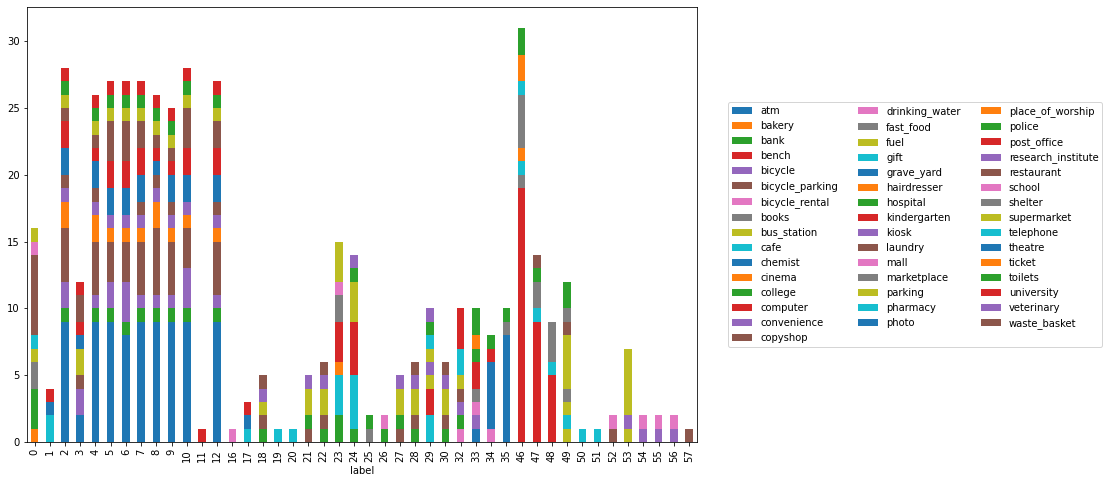

In [11]:
poi_types_per_staypoint = staypoints_pois.groupby(['label', 'poi_type'])['label'].count().unstack('poi_type')
poi_types_per_staypoint.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.04, 0.5))

Wenn wir die Haltepunkte auf einer Karte anzeigen können wir überprüfen, ob die Resultate Sinn machen. Können sie aufgrund obenstehender Abbildung erraten, welche Haltepunkte wo sind? Was erschwert diese Aufgabe?

**Lösung**: Es gibt im Datensatz auch POI wie Sitzbänke - diese können die Interpretation erschweren. OSM Daten sind VGI (Volunteered Geographic Information), insofern unterscheidet sich die Datenqualität stark von Ort zu Ort.

In [12]:
m = Map(center=(40.0, 116.32), zoom=11)
for idx, pt in staypoints.iterrows():
    circle_marker = CircleMarker(location=(pt['geometry'].y, pt['geometry'].x), radius=2)
    msg = HTML()
    msg.value = f"{pt['label']}"
    circle_marker.popup = msg
    m.add_layer(circle_marker)
m

Map(center=[40.0, 116.32], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### 4) POI aus OSM extrahieren und mit Triplegs verknüpfen

Schauen wir uns nun die Triplegs an. Hier verfolgen wir eine andere Idee, nämlich dass wir abschätzen können, ob eine Reise mit dem öffentlichen Verkehr durchgeführt wurde, indem wir die Haltestellen des ÖV entlang der Route zählen.

#### POI aus OSM

Dafür müssen wir wieder die entsprechenden Objekte aus dem OSM-Datensatz extrahieren. Hierbei suchen wir Objekte mit `public_transport=stop_position` (siehe auch https://wiki.openstreetmap.org/wiki/Tag:public_transport%3Dstop_position). Implementieren sie wieder entsprechend einen Filter (siehe https://pyrosm.readthedocs.io/en/latest/basics.html#Read-OSM-data-with-custom-filter).

<AxesSubplot:>

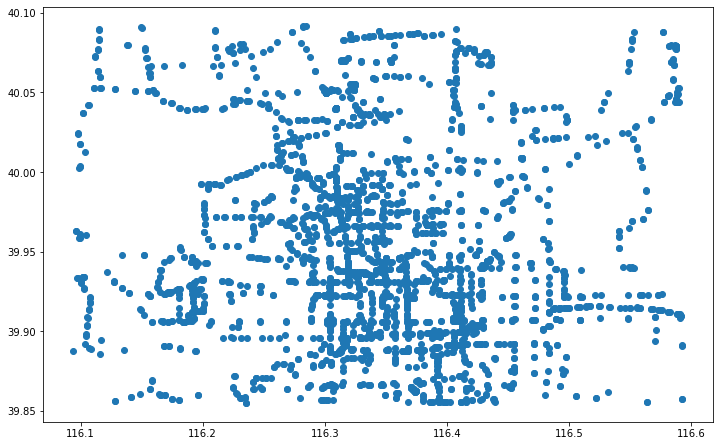

In [13]:
# TODO Implement filter for OSM data that contains public_transport=stop_position.
custom_filter = {'public_transport': ['stop_position']}
pt_stops = osm.get_pois(custom_filter=custom_filter)
pt_stops['geometry'] = pt_stops.apply(lambda r: pygeos_geometry_to_shapely(r.geometry), axis=1)
pt_stops = pt_stops.set_geometry('geometry')
pt_stops.plot(figsize=(12, 8))

#### Triplegs aus GeoLife

Von den gleichen Personen benutzen wir nun die triplegs. Wiederum wenden wir die Funktion `wkt.loads` an, um den well-known-text in ein `shapely`-Objekt umzuwandeln. Zusätzlich müssen wir die `start_time` und die `end_time` von einem Unix-Zeitstempel in ein Python `datetime`-Objekt umwandeln.

Importieren sie das GeoLife-CSV.

<AxesSubplot:>

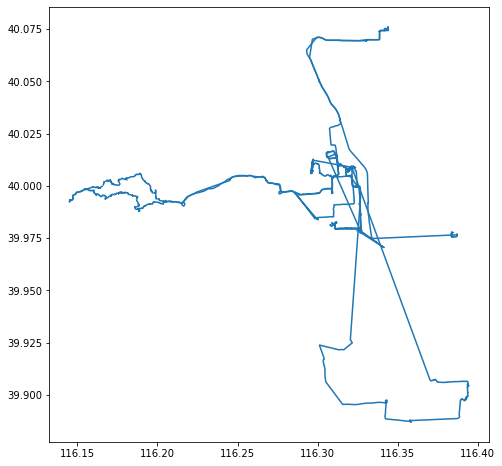

In [14]:
# TODO Import geolife_triplegs.csv file.
triplegs = pd.read_csv('input_data/geolife_triplegs.csv')
triplegs['geometry'] = triplegs['geometry'].apply(wkt.loads)
triplegs['start_time'] = pd.to_datetime(triplegs['start_time'], unit='s')
triplegs['end_time'] = pd.to_datetime(triplegs['end_time'], unit='s')
triplegs = gpd.GeoDataFrame(triplegs, crs='epsg:4326')

triplegs.plot(figsize=(12, 8))

Betrachten sie den Datensatz wie gewohnt mit `.head(...)`. 

In [15]:
# TODO Examine the data using .head(...), etc.
triplegs.head(3)

,label,user_id,start_time,end_time,geometry
0,0,0,2008-10-23 03:05:15,2008-10-23 04:34:42,"LINESTRING (116.29866 39.98402, 116.28680 39.9..."
1,1,0,2008-10-23 04:34:52,2008-10-23 09:55:31,"LINESTRING (116.32489 39.99977, 116.32016 40.0..."
2,2,0,2008-10-23 10:02:29,2008-10-23 10:20:56,"LINESTRING (116.32185 40.00932, 116.32089 40.0..."


#### Umwandlung in projiziertes Koordinatensystem, Puffern und spatial Join

In gleicher Weise wie zuvor wollen wir wieder das Koordinatensystem von WGS 1984 auf EPSG:4479 umstellen, da das letztere uns erlaubt, Längen in Meter anzugeben. Kreieren sie dann mit der Funktion `buffer(dist)` einen Puffer um die triplegs, und nutzen sie die `gpd.sjoin(...)`-Funktion um einen räumlichen Join zwischen den gepufferten Haltepunkten und den POI durchzuführen. Sehen sie sich die Daten mit `.head(...)` an und überprüfen sie ob die Ergebnisse Sinn machen.

In [16]:
# TODO Change the coordinate systems appropriately.
triplegs_4479 = triplegs.to_crs('EPSG:4479')
pt_stops_4479 = pt_stops.to_crs('EPSG:4479')
triplegs_buffer = triplegs_4479.copy()
# TODO Create buffer of reasonable size arount triplegs.
triplegs_buffer['geometry'] = triplegs_buffer.buffer(150)

# TODO Use geopanda's sjoin function to join the two datasets (use how='left').
triplegs_pois = gpd.sjoin(triplegs_buffer, pt_stops_4479, how='left')
triplegs_pois = triplegs_pois.reset_index()

Wir zählen nun die Stopps um jedes tripleg. Da die Totale Anzahl wenig Aussagekraft hat, normalisieren wir die Anzahl der Stopps entlang der Route mit der Länge der Route.

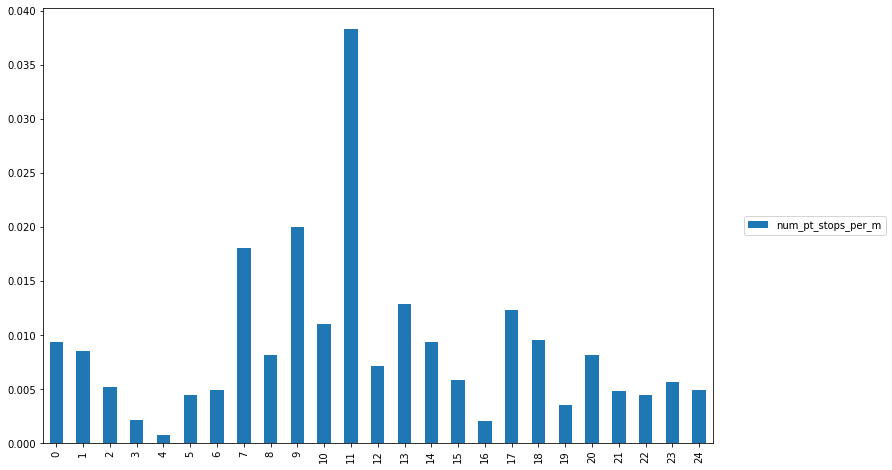

In [17]:
poi_types_per_tripleg = triplegs_pois.groupby(['label', 'public_transport'])['label'].count().unstack('public_transport')
poi_types_per_tripleg = triplegs_4479.merge(poi_types_per_tripleg, left_on='label', right_on='label')
poi_types_per_tripleg['num_pt_stops_per_m'] = poi_types_per_tripleg['stop_position'] / poi_types_per_tripleg.geometry.length
poi_types_per_tripleg['num_pt_stops_per_m'].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.04, 0.5))

Das Darstellen auf einer Karte erlaubt uns wieder, zu interpretieren ob die Ergebnisse Sinn machen. Können sie erraten, welche Route eventuell mit dem ÖV zurückgelegt wurde? Stimmt das mit obenstehender Abbildung überein?

**Lösung**: Die Route 11 könnte mit dem ÖV zurückgelegt worden sein. 

In [18]:
label = ipyw.Label(layout=ipyw.Layout(width='80%'))

m = Map(center=(40.0, 116.32), zoom=11)
triplegs_for_map = triplegs.drop(['start_time', 'end_time'], axis=1)
triplegs_data = GeoData(geo_dataframe=triplegs_for_map,
                        hover_style={'color': 'red', 'fillOpacity': 0.2},
                        name='Triplegs')
def hover_handler(event=None, feature=None, id=None, properties=None):
    label.value = str(properties['label'])

triplegs_data.on_hover(hover_handler)
m.add_layer(triplegs_data)

ipyw.VBox([m, label])

### 5) Strassentypen aus OSM extrahieren und mit Triplegs verknüpfen

Zu guter letzt wollen wir die Korrelation zwischen Strassentyp und Geschwindigkeit untersuchen. Dazu verwenden wir nicht POI sondern die Strassen die in OSM verfügbar sind.

#### Strassen aus OSM

Wir extrahieren dazu zuerst alle Strassen aus dem OSM-Datensatz. Mit der `pyrosm`-Bibliothek können wir das tun, indem wir den `network_type` auf `driving` setzen.

<AxesSubplot:>

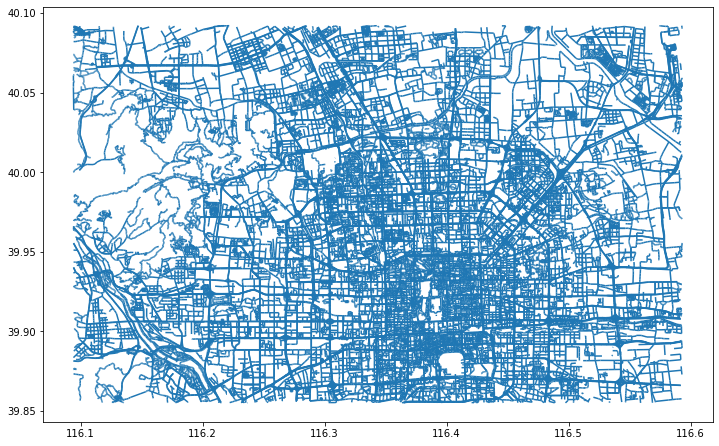

In [19]:
drive_net = osm.get_network(network_type="driving")
drive_net.plot(figsize=(12, 8))

Als nächstes müssen wir zu jedem tripleg herausfinden, entlang welcher Strassen es verläuft. Sie können sich bereits vorstellen, dass das nicht ganz trivial ist. Als mögliche Ansätze kommen z.B. in Frage:

1. Wir finden die nächste Strasse zu jedem Stützpunkt der tripleg-Geometrie und zählen die Strassentypen.
2. Wir legen einen Puffer um die Strasse, kreieren eine Intersection mit den Strassen und zählen alle Strassen die vorkommen.
3. Wir "resamplen" jedes tripleg (um einen Stützpunkt z.B. alle 100m zu bekommen), und wenden die gleiche Strategie wie in Punkt 1 an.

Überlegen sie sich Vor- und Nachteile jedes Ansatzes. 

**Lösung**: 1. Die Stützpunkte können sehr unregelmässig sein, was zu einer falschen Einschätzung führen könnte. 2. So könnten u.U. viele Nebenstrassen mitgezählt werden. 3. Auch hier gibt es natürlich Raum für Fehler, z.B. hängt der Ansatz von der Resampling-Frequenz ab.

#### Resamplen der Trajektorien

Wir wählen den dritten Ansatz, weil er eine gute Balance zwischen Implementationsaufwand und Genauigkeit liefert. Zuerst müssen wir die Anzahl der "Resampling-Punkte" berechnen (z.B. einen Punkt alle 100 m). Verwenden sie die Gesamtlänge des triplegs (`triplegs_res.geometry.length`) um die Anzahl der Punkte zu bestimmen.

In [20]:
triplegs_res = triplegs_4479.copy()
# TODO Compute how many "resampling points" we need along the whole geometry.
triplegs_res['num_resample_points'] = triplegs_res.geometry.length / 100

In [21]:
triplegs_res['resampled'] = triplegs_res.apply(lambda r: [r.geometry.interpolate(i / max(1, float(int(r['num_resample_points']))), normalized=True) \
                                                          for i in range(int(r['num_resample_points']) + 1)], axis=1)

In [22]:
triplegs_res = triplegs_res.drop(['start_time', 'end_time', 'geometry', 'num_resample_points'], axis=1)
triplegs_res = triplegs_res.rename(columns={'Unnamed: 0': 'label'})

In [23]:
# TODO Examine the DataFrame with the resampled points.
triplegs_res.head(3)

,label,user_id,resampled
0,0,0,"[POINT (-2168220.683270521 4387318.920940959),..."
1,1,0,"[POINT (-2169730.023073904 4385318.758930436),..."
2,2,0,"[POINT (-2169195.485905852 4384822.927004611),..."


Wir haben nun eine Liste von Punkten zu jedem tripleg. Mit der `explode`-Funktion teilen wir diese in einzelne Zeilen auf.

In [24]:
triplegs_res = pd.DataFrame(triplegs_res)
# TODO Use the .explode(...) function on the triplegs_res DataFrame.
triplegs_res = triplegs_res.explode('resampled')
triplegs_res = triplegs_res.rename(columns={'resampled': 'geometry'})
triplegs_res = gpd.GeoDataFrame(triplegs_res, geometry='geometry')

Untersuchen sie das `triplegs_res`-GeoDataFrame mit der `.head(...)`-Funktion.

In [25]:
# TODO Examine the resulting DataFrame using .head(...), etc.
triplegs_res.head(3)

,label,user_id,geometry
0,0,0,POINT (-2168220.683 4387318.921)
0,0,0,POINT (-2168122.848 4387295.738)
0,0,0,POINT (-2168025.013 4387272.556)


Die folgende Funktion findet den "besten" Strassentyp, indem sie folgende Prozedur anwendet.

* Finde Kandidaten in der Umgebung, mit der `extent`-Variable definiert (dies hat insbesondere zum Zweck, dass nur eine kleinere Anzahl Strassensegmente in der Umgebung untersucht werden muss).
* Berechne die kürzeste Distanz (`dist`) vom Stützpunkt zum Strassen-Kandidaten (mithilfe der `shapely`-Funktion `project`).
* Behalte nur den Kandidaten mit der kürzesten Distanz.
* Gib den Strassentyp dieses Kandidaten zurück.

In [26]:
drive_net_4479 = drive_net.to_crs('EPSG:4479')
extent = 100

def find_road_type(row):
    lon = row.geometry.x
    lat = row.geometry.y
    candidate_region = Polygon([(lon - extent, lat - extent), (lon + extent, lat - extent), 
                                (lon + extent, lat + extent), (lon - extent, lat + extent)])
    candidate_region_df = gpd.GeoDataFrame([{'geometry': candidate_region}], crs='EPSG:4479')
    
    roads = gpd.sjoin(candidate_region_df, drive_net_4479, how='inner', op='intersects')
    roads_dists = []
    for idx, road in roads.iterrows():
        orig_road = drive_net.loc[road.index_right]
        along_line = orig_road.geometry.project(row.geometry)
        pt = orig_road.geometry.interpolate(along_line)
        # TODO Compute the distance between the original point (row.geometry) and the point projected to the candidate road.
        dist = pt.distance(row.geometry)
        roads_dists.append({
            'dist': dist,
            'road': road
        })
    roads_dists = pd.DataFrame(roads_dists)
    if len(roads_dists) > 0:
        roads_dists = roads_dists.sort_values('dist')
        best_road = roads_dists.iloc[0]['road']
        best_dist = roads_dists.iloc[0]['dist']
        return best_road['highway']
    else:
        return 'None'

Probieren sie die Funktion mit ein paar triplegs aus (sie können auf ein einzelnes mittels `triplegs_res.iloc[...]` zugreifen).

In [27]:
# TODO Apply your function to a single tripleg.
best_road = find_road_type(triplegs_res.iloc[0])
print(f"The closest road is of type {best_road}.")

The closest road is of type tertiary.


Wir wenden die Funktion nun auf alle triplegs an.

In [28]:
triplegs_res['road_type'] = triplegs_res.apply(find_road_type, axis=1)

Schliesslich müssen wir noch die Strassentypen von allen Stützpunkten eines triplegs aufsummieren.

In [29]:
triplegs_aggr = triplegs_res.groupby(['label', 'road_type'])['road_type'].count()
triplegs_max = triplegs_aggr[triplegs_aggr == triplegs_aggr.groupby(level=[0]).transform(max)]
triplegs_max = triplegs_max.to_frame()
triplegs_max = triplegs_max.rename(columns={'road_type': 'num_occurrences'})
triplegs_max = triplegs_max.reset_index()
triplegs_max = triplegs_max.drop_duplicates(subset=['label', 'road_type'])
triplegs_max.head(3)

,label,road_type,num_occurrences
0,0,tertiary,24
1,1,service,9
2,2,service,13


Zum Schluss können wir die zwei DataFrames mittels `merge` (über die gemeinsame Kolonne `label`) zusammenbringen.

In [30]:
# TODO Use merge (on the label columns) to join the original triplegs_4479 DataFrame with the created one triplegs_max.
triplegs_road_types = triplegs_4479.merge(triplegs_max, left_on='label', right_on='label')
triplegs_road_types.head(3)

,label,user_id,start_time,end_time,geometry,road_type,num_occurrences
0,0,0,2008-10-23 03:05:15,2008-10-23 04:34:42,"LINESTRING (-2168220.683 4387318.921, -2166940...",tertiary,24
1,1,0,2008-10-23 04:34:52,2008-10-23 09:55:31,"LINESTRING (-2169730.023 4385318.759, -2169209...",service,9
2,2,0,2008-10-23 10:02:29,2008-10-23 10:20:56,"LINESTRING (-2169195.486 4384822.927, -2169118...",service,13


Da wir interessiert daran sind, wie der Strassentyp und die Geschwindigkeit korrelieren, müssen wir letztere noch berechnen und zum DataFrame hinzufügen.

In [31]:
triplegs_road_types['duration'] = (triplegs_road_types['end_time'] - 
                                   triplegs_road_types['start_time']).apply(lambda r: r.total_seconds())
# TODO Compute the speed along a tripleg.
triplegs_road_types['speed'] = triplegs_road_types.geometry.length / triplegs_road_types['duration']

Zu guter letzt können wir eine Abbildung erstellen, welche die Korrelation gut aufzeigt.

<AxesSubplot:xlabel='speed', ylabel='road_type'>

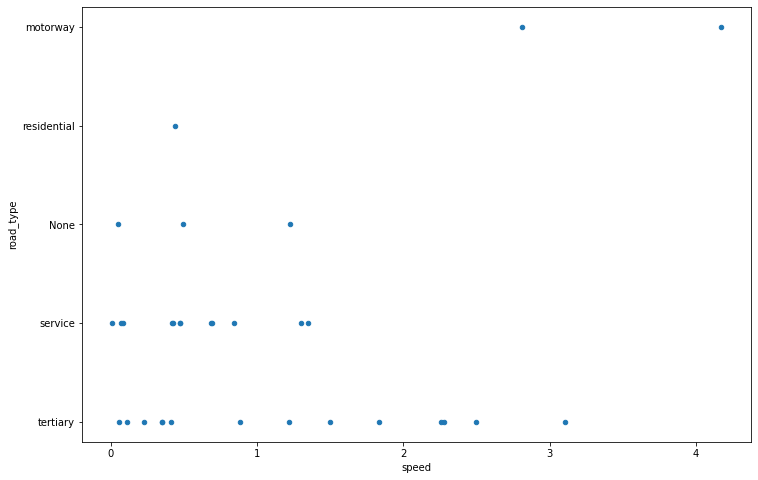

In [32]:
triplegs_road_types_filtered = pd.DataFrame(triplegs_road_types[~(triplegs_road_types['num_occurrences'] < 5)])
triplegs_road_types_filtered.plot.scatter(x='speed', y='road_type', figsize=(12, 8))

### 6) Weiterführende Aufgaben

Wir haben die POI nicht weiter in Klassen unterteilt. Überlegen sie sich sinnvolle Klassen und ersetzen sie die einzelnen POI-Typen durch deren Klassen (z.B. "Freizeit", "Ausbildung", "Wohnen", "Ausgang", ...).